In [1]:
from collections import defaultdict
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import pandas as pd
import seaborn as sns
import os

from howso.nominal_substitution.substitution_engine import NominalSubstitutionEngine
from howso.synthesizer import Synthesizer
from howso.utilities import infer_feature_attributes
from howso.validator import Validator
from howso.validator.results import ValidatorResult


os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Set this to True if the dataset is deemed to already have been anonymized.
ALREADY_ANONYMIZED: bool = True

In [2]:
col_type_mapping = {
    'nih_age': 'Int64', 'nih_alcohol_frequency': 'Int64', 'nih_sex': 'Int64', 'nih_asthma': 'Int64',
    'nih_alc_sub_abuse': 'Int64', 'nih_autoimm': 'Int64', 'nih_cancer_past_yr': 'Int64',
    'nih_chronic_kidney_disease': 'Int64', 'nih_chronic_lung': 'Int64', 'nih_copd': 'Int64',
    'nih_cardiovascular_disease': 'Int64', 'nih_depression': 'Int64', 'nih_diabetes': 'Int64',
    'nih_hypertension': 'Int64', 'nih_immunocompromised': 'Int64', 'nih_iv_drug_use': 'Int64',
    'nih_other_chronic_cond': 'Int64', 'nih_mental_health_disorder': 'Int64',
    'nih_sickle_cell_disease': 'Int64', 'cov_pan_chal_hlth_2': 'Int64', 'cov_pan_chal_med_2': 'Int64',
    'cov_pan_chlng_trans_2': 'Int64', 'cov_tst_mthd_2': 'Int64', 'nih_abdom_pain': 'Int64',
    'covid_barrier___1': 'Int64', 'covid_barrier___2': 'Int64', 'covid_barrier___3': 'Int64',
    'covid_barrier___4': 'Int64', 'covid_barrier___5': 'Int64', 'covid_barrier___6': 'Int64',
    'covid_barrier___7': 'Int64', 'covid_barrier___8': 'Int64', 'covid_barrier___9': 'Int64',
    'covid_barrier___98': 'Int64', 'covid_barrier___99': 'Int64', 'nih_cough': 'Int64',
    'nih_diff_breath': 'Int64', 'nih_fatigue': 'Int64', 'nih_fever_chills': 'Int64', 'nih_headache': 'Int64',
    'nih_muscle_ache': 'Int64', 'nih_nausea_vomiting_diarrhea': 'Int64', 'nih_olfactory': 'Int64',
    'nih_other_symp': 'Int64', 'covid_pandemic_challenges_abod_2': 'Int64',
    'covid_pandemic_challenges_food_2': 'Int64', 'covid_pandemic_challenges_wate_2': 'Int64',
    'nih_throat_congestion_nose': 'Int64', 'nih_skin_rash': 'Int64', 'covid_test_approval': 'Int64',
    'covid_test_collection_setting': 'Int64', 'covid_test_performed_location': 'Int64',
    'covid_test_result': 'Int64', 'covid_test_specimen_collector': 'Int64', 'covid_test_specimen_type': 'Int64',
    'covid_test_study_setting': 'Int64', 'covid_test_tar_dis_stat_2___1': 'Int64',
    'covid_test_tar_dis_stat_2___3': 'Int64', 'covid_test_tar_dis_stat_2___6': 'Int64',
    'covid_test_type': 'Int64', 'covid_vaccine': 'Int64', 'nih_employment': 'Int64',
    'during_worriedothers': 'Int64', 'during_worriedschool': 'Int64', 'nih_education': 'Int64',
    'eligible_plans': 'Int64', 'employed_ew': 'Int64', 'employed_healthcare_2': 'Int64',
    'family_income': 'Int64', 'flu_vaccine_season_3': 'Int64', 'flu_vaccinehistind_2': 'Int64',
    'gender_identity_term_2': 'Int64', 'hc_notrec': 'Int64', 'hc_notrec_detail___1': 'Int64',
    'hc_notrec_detail___2': 'Int64', 'hc_notrec_detail___3': 'Int64', 'hc_notrec_detail___4': 'Int64',
    'hc_notrec_detail___5': 'Int64', 'hc_notrec_detail___6': 'Int64', 'nih_insurance': 'Int64',
    'hi_loss_covid': 'Int64', 'household_congregate_3': 'Int64', 'household_famgen_3': 'Int64',
    'household_homeless': 'Int64', 'isolate_maintain_job': 'Int64', 'jobloss_covid19_2': 'Int64',
    'language_english': 'Int64', 'language_home___1': 'Int64', 'language_home___2': 'Int64',
    'language_home___3': 'Int64', 'language_home___4': 'Int64', 'language_home___5': 'Int64',
    'language_home___6': 'Int64', 'language_home___7': 'Int64', 'language_home___8': 'Int64',
    'language_home___9': 'Int64', 'language_home___90': 'Int64', 'language_home___99': 'Int64',
    'nih_lifetime_use_alcohol': 'Int64', 'physical_health': 'Int64', 'positivemonth_covidtest_2': 'Int64',
    'positiveyear_covidtest_3': 'Int64', 'nih_pregnancy': 'Int64', 'quarantine_maintain_job': 'Int64',
    'race_ethn_asian_detail_3___1': 'Int64', 'race_ethn_asian_detail_3___2': 'Int64',
    'race_ethn_asian_detail_3___3': 'Int64', 'race_ethn_asian_detail_3___4': 'Int64',
    'race_ethn_asian_detail_3___5': 'Int64', 'nih_ethnicity': 'Int64',
    'race_ethn_hispanic_detail_2___1': 'Int64', 'race_ethn_hispanic_detail_2___2': 'Int64',
    'race_ethn_hispanic_detail_2___3': 'Int64', 'race_ethn_hispanic_detail_2___4': 'Int64',
    'race_ethn_hispanic_detail_2___5': 'Int64', 'race_ethn_hispanic_detail_2___6': 'Int64',
    'race_ethn_hispanic_detail_2___7': 'Int64', 'race_ethn_islander_detail_2___1': 'Int64',
    'race_ethn_islander_detail_2___10': 'Int64', 'race_ethn_islander_detail_2___11': 'Int64',
    'race_ethn_islander_detail_2___12': 'Int64', 'race_ethn_islander_detail_2___13': 'Int64',
    'race_ethn_islander_detail_2___14': 'Int64', 'race_ethn_islander_detail_2___2': 'Int64',
    'race_ethn_islander_detail_2___3': 'Int64', 'race_ethn_islander_detail_2___4': 'Int64',
    'race_ethn_islander_detail_2___5': 'Int64', 'race_ethn_islander_detail_2___6': 'Int64',
    'race_ethn_islander_detail_2___7': 'Int64', 'race_ethn_islander_detail_2___8': 'Int64',
    'race_ethn_islander_detail_2___9': 'Int64', 'recentmonth_covidtest_2': 'Int64',
    'recentresult_covidtest': 'Int64', 'recentyear_covidtest_3': 'Int64', 'nih_disability': 'Int64',
    'nih_health_status': 'Int64', 'sex_orient_id': 'Int64', 'nih_history_smoking': 'Int64',
    'smoker_number': 'float64', 'test_accesseasy_2': 'Int64', 'test_accesswhere_2': 'Int64',
    'test_pbenearound_2': 'Int64', 'test_pbeneexposed_2': 'Int64', 'test_pbenepos_2': 'Int64',
    'test_pbenesafe_2': 'Int64', 'test_pbenework_2': 'Int64', 'test_pbeneworry_2': 'Int64',
    'test_priskcontact_2': 'Int64', 'test_priskhlthcare_2': 'Int64', 'test_priskknow_2': 'Int64',
    'test_prisklater_2': 'Int64', 'test_prisknohelp_2': 'Int64', 'test_prisknosymp_2': 'Int64',
    'test_priskouch_2': 'Int64', 'tested_for_covid': 'Int64', 'tested_positive_for_covid': 'Int64',
    'vaccine_avail': 'Int64', 'vaccine_concerns_3___1': 'Int64', 'vaccine_concerns_3___10': 'Int64',
    'vaccine_concerns_3___2': 'Int64', 'vaccine_concerns_3___3': 'Int64', 'vaccine_concerns_3___4': 'Int64',
    'vaccine_concerns_3___5': 'Int64', 'vaccine_concerns_3___6': 'Int64', 'vaccine_concerns_3___7': 'Int64',
    'vaccine_concerns_3___8': 'Int64', 'vaccine_concerns_3___9': 'Int64', 'vaccine_dose': 'Int64',
    'vaccine_reasons_3___1': 'Int64', 'vaccine_reasons_3___2': 'Int64', 'vaccine_reasons_3___3': 'Int64',
    'vaccine_reasons_3___4': 'Int64', 'vaccine_reasons_3___5': 'Int64', 'vaccine_reasons_3___6': 'Int64',
    'vaccine_reasons_3___7': 'Int64', 'vaccine_reasons_3___8': 'Int64', 'vaccine_reasons_3___9': 'Int64',
    'nih_vape_freq': 'Int64', 'work_closecont_2': 'Int64', 'work_ppe_2': 'Int64', 'work_wash_2': 'Int64',
    'nih_zip': 'string', 'nih_weight': 'Int64', 'nih_height': 'Int64', 'nih_race': 'Int64',
    'nih_alcohol_yn': 'Int64', 'nih_cig_smoke_freq': 'Int64', 'nih_smoking_yn': 'Int64'}
print(f'total number of columns being mapped: {len(col_type_mapping)}')

data_path = Path("/home", "sagemaker-user", "phs002878", "project84_DATA_transformcopy_v3_processed.csv")
df = pd.read_csv(data_path, dtype=col_type_mapping)
df = df.reset_index(drop=True)
print(df.columns)
print(f'total number of rows: {len(df)}')

# for model comparison for covid_test_result prediction, nulls from target feature should be removed and all-null columns should be removed as well
target_feature = 'tested_positive_for_covid'
df = df.dropna(subset=[target_feature])
df = df[df[target_feature] != 3]
print(f'after removing null and extraneous rows, df.shape: {df.shape}')
null_only_cols = df.columns[df.isna().all()].tolist()
print(f'null-only columns: {null_only_cols}')
df = df.drop(columns=null_only_cols)
df = df.drop(columns='index')
df = df.reset_index(drop=True)
print(f'input dataframe shape after processing: {df.shape}')
pd.set_option('display.max_columns', None)
df.describe()

total number of columns being mapped: 188
Index(['index', 'nih_age', 'nih_alcohol_frequency', 'nih_sex', 'nih_asthma',
       'nih_alc_sub_abuse', 'nih_autoimm', 'nih_cancer_past_yr',
       'nih_chronic_kidney_disease', 'nih_chronic_lung',
       ...
       'work_closecont_2', 'work_ppe_2', 'work_wash_2', 'nih_zip',
       'nih_weight', 'nih_height', 'nih_race', 'nih_alcohol_yn',
       'nih_cig_smoke_freq', 'nih_smoking_yn'],
      dtype='object', length=189)
total number of rows: 44553
after removing null and extraneous rows, df.shape: (4456, 189)
null-only columns: []
input dataframe shape after processing: (4456, 188)


,nih_age,nih_alcohol_frequency,nih_sex,nih_asthma,nih_alc_sub_abuse,nih_autoimm,nih_cancer_past_yr,nih_chronic_kidney_disease,nih_chronic_lung,nih_copd,nih_cardiovascular_disease,nih_depression,nih_diabetes,nih_hypertension,nih_immunocompromised,nih_iv_drug_use,nih_other_chronic_cond,nih_mental_health_disorder,nih_sickle_cell_disease,cov_pan_chal_hlth_2,cov_pan_chal_med_2,cov_pan_chlng_trans_2,cov_tst_mthd_2,nih_abdom_pain,covid_barrier___1,covid_barrier___2,covid_barrier___3,covid_barrier___4,covid_barrier___5,covid_barrier___6,covid_barrier___7,covid_barrier___8,covid_barrier___9,covid_barrier___98,covid_barrier___99,nih_cough,nih_diff_breath,nih_fatigue,nih_fever_chills,nih_headache,nih_muscle_ache,nih_nausea_vomiting_diarrhea,nih_olfactory,nih_other_symp,covid_pandemic_challenges_abod_2,covid_pandemic_challenges_food_2,covid_pandemic_challenges_wate_2,nih_throat_congestion_nose,nih_skin_rash,covid_test_approval,covid_test_collection_setting,covid_test_performed_location,covid_test_result,covid_test_specimen_collector,covid_test_specimen_type,covid_test_study_setting,covid_test_tar_dis_stat_2___1,covid_test_tar_dis_stat_2___3,covid_test_tar_dis_stat_2___6,covid_test_type,covid_vaccine,nih_employment,during_worriedothers,during_worriedschool,nih_education,eligible_plans,employed_ew,employed_healthcare_2,family_income,flu_vaccine_season_3,flu_vaccinehistind_2,gender_identity_term_2,hc_notrec,hc_notrec_detail___1,hc_notrec_detail___2,hc_notrec_detail___3,hc_notrec_detail___4,hc_notrec_detail___5,hc_notrec_detail___6,nih_insurance,hi_loss_covid,household_congregate_3,household_famgen_3,household_homeless,isolate_maintain_job,jobloss_covid19_2,language_english,language_home___1,language_home___2,language_home___3,language_home___4,language_home___5,language_home___6,language_home___7,language_home___8,language_home___9,language_home___90,language_home___99,nih_lifetime_use_alcohol,physical_health,positivemonth_covidtest_2,positiveyear_covidtest_3,nih_pregnancy,quarantine_maintain_job,race_ethn_asian_detail_3___1,race_ethn_asian_detail_3___2,race_ethn_asian_detail_3___3,race_ethn_asian_detail_3___4,race_ethn_asian_detail_3___5,nih_ethnicity,race_ethn_hispanic_detail_2___1,race_ethn_hispanic_detail_2___2,race_ethn_hispanic_detail_2___3,race_ethn_hispanic_detail_2___4,race_ethn_hispanic_detail_2___5,race_ethn_hispanic_detail_2___6,race_ethn_hispanic_detail_2___7,race_ethn_islander_detail_2___1,race_ethn_islander_detail_2___10,race_ethn_islander_detail_2___11,race_ethn_islander_detail_2___12,race_ethn_islander_detail_2___13,race_ethn_islander_detail_2___14,race_ethn_islander_detail_2___2,race_ethn_islander_detail_2___3,race_ethn_islander_detail_2___4,race_ethn_islander_detail_2___5,race_ethn_islander_detail_2___6,race_ethn_islander_detail_2___7,race_ethn_islander_detail_2___8,race_ethn_islander_detail_2___9,recentmonth_covidtest_2,recentresult_covidtest,recentyear_covidtest_3,nih_disability,nih_health_status,sex_orient_id,nih_history_smoking,smoker_number,test_accesseasy_2,test_accesswhere_2,test_pbenearound_2,test_pbeneexposed_2,test_pbenepos_2,test_pbenesafe_2,test_pbenework_2,test_pbeneworry_2,test_priskcontact_2,test_priskhlthcare_2,test_priskknow_2,test_prisklater_2,test_prisknohelp_2,test_prisknosymp_2,test_priskouch_2,tested_for_covid,tested_positive_for_covid,vaccine_avail,vaccine_concerns_3___1,vaccine_concerns_3___10,vaccine_concerns_3___2,vaccine_concerns_3___3,vaccine_concerns_3___4,vaccine_concerns_3___5,vaccine_concerns_3___6,vaccine_concerns_3___7,vaccine_concerns_3___8,vaccine_concerns_3___9,vaccine_dose,vaccine_reasons_3___1,vaccine_reasons_3___2,vaccine_reasons_3___3,vaccine_reasons_3___4,vaccine_reasons_3___5,vaccine_reasons_3___6,vaccine_reasons_3___7,vaccine_reasons_3___8,vaccine_reasons_3___9,nih_vape_freq,work_closecont_2,work_ppe_2,work_wash_2,nih_weight,nih_height,nih_race,nih_alcohol_yn,nih_cig_smoke_freq,nih_smoking_yn
count,4154.0,776.0,4154.0,4154.0,4154.0,4154.0,4154.0,4154.0,4154.0,4154.0,4154.0,4154.0

In [3]:
continuous_feats: list[str] = [
    'nih_height', 'vaccine_dose', 'nih_weight', 'nih_age', 'smoker_number'
]

# These features have been decided to be personally-identifying and, if they
# have not already been anonymized, will be replaced with novel nominals.
sensitive_nominal_feats: dict[str, str] = {
    "nih_zip": "int-id"
}

# These are non-personally-identifying nominals. Their values may be present in
# the resulting synthetic data, but necessary to maintain the predictiveness of
# the resulting synthetic data.
nominal_feats = list(set(df.columns) - set(continuous_feats) - set(sensitive_nominal_feats.keys()))
print(nominal_feats)

['race_ethn_islander_detail_2___4', 'nih_diabetes', 'recentyear_covidtest_3', 'nih_smoking_yn', 'race_ethn_islander_detail_2___9', 'nih_lifetime_use_alcohol', 'nih_employment', 'household_homeless', 'nih_muscle_ache', 'nih_cig_smoke_freq', 'nih_other_chronic_cond', 'covid_test_study_setting', 'quarantine_maintain_job', 'test_prisklater_2', 'race_ethn_islander_detail_2___14', 'covid_barrier___99', 'flu_vaccinehistind_2', 'nih_chronic_kidney_disease', 'language_home___90', 'employed_ew', 'vaccine_concerns_3___10', 'vaccine_reasons_3___9', 'household_famgen_3', 'work_closecont_2', 'during_worriedothers', 'language_home___2', 'nih_alcohol_frequency', 'language_home___5', 'nih_pregnancy', 'test_priskouch_2', 'tested_positive_for_covid', 'nih_fatigue', 'nih_vape_freq', 'race_ethn_islander_detail_2___11', 'language_home___7', 'vaccine_concerns_3___4', 'test_pbenepos_2', 'race_ethn_asian_detail_3___1', 'test_priskhlthcare_2', 'race_ethn_hispanic_detail_2___3', 'gender_identity_term_2', 'hc_not

In [4]:
# Compute feature attributes
features = infer_feature_attributes(
    df,
    types={
        "continuous": continuous_feats,
        "nominal": list(sensitive_nominal_feats.keys()) + nominal_feats
    },
    # Let's use tight-bounds for the continuous
    tight_bounds=continuous_feats,
)

# Non-sensitive nominals should be marked as such
for nominal in nominal_feats:
    features[nominal]["non_sensitive"] = True

if ALREADY_ANONYMIZED:
    # If data is already anonymized, mark the "sensitive" features non-sensitive too.
    for nominal in sensitive_nominal_feats.keys():
        features[nominal]["non_sensitive"] = True
else:
    # Let's mark the sensitive nominals with the desired subtypes
    for nominal, subtype in sensitive_nominal_feats.items():
        features[nominal]["subtype"] = subtype

features.to_dataframe()


type decimal_places bounds                    \
                                                    min    max allow_null   
nih_age                continuous            0.0    2.0   81.0       True   
nih_alcohol_frequency     nominal            0.0    NaN    NaN       True   
nih_sex                   nominal            0.0    NaN    NaN       True   
nih_asthma                nominal            0.0    NaN    NaN       True   
nih_alc_sub_abuse         nominal            0.0    NaN    NaN       True   
...                           ...            ...    ...    ...        ...   
nih_height             continuous            0.0    1.0  118.0       True   
nih_race                  nominal            0.0    NaN    NaN       True   
nih_alcohol_yn            nominal            0.0    NaN    NaN       True   
nih_cig_smoke_freq        nominal            0.0    NaN    NaN       True   
nih_smoking_yn            nominal            0.0    NaN    NaN       True   

                                                data_type non_sensitive  \
                      observed_min observed_max                           
nih_age                        2.0         81.0    number           NaN   
nih_alcohol_frequency          NaN          NaN    number          True   
nih_sex                        NaN          NaN    number          True   
nih_asthma                     NaN          NaN    number          True   
nih_alc_sub_abuse              NaN          NaN    number          True   
...                            ...          ...       ...           ...   
nih_height                     1.0        118.0    number           NaN   
nih_race                       NaN          NaN    number          True   
nih_alcohol_yn                 NaN          NaN    number          True   
nih_cig_smoke_freq             NaN          NaN    number          True   
nih_smoking_yn                 NaN          NaN    number          True   

                      original_type       
                          data_type size  
nih_age                     integer  8.0  
nih_alcohol_frequency       integer  8.0  
nih_sex                     integer  8.0  
nih_asthma                  integer  8.0  
nih_alc_sub_abuse           integer  8.0  
...                             ...  ...  
nih_height                  integer  8.0  
nih_race                    integer  8.0  
nih_alcohol_yn              integer  8.0  
nih_cig_smoke_freq          integer  8.0  
nih_smoking_yn              integer  8.0  

[188 rows x 11 columns]

In [5]:
if not ALREADY_ANONYMIZED:
    # Before continuing, let's substitute sensitive features with replacement nominals.

    # Instantiate the NominalSubstitutionEngine
    substitution_engine = NominalSubstitutionEngine.factory(nominal_substitution_config={
        "nominals": {"default": {"locales": ["en_US"], "substitution": "naive"}},
    })
    df = substitution_engine.apply_substitutions(features, df)

    # Now that these replacements have been made, we no longer need these marked as sensitive.
    for feature in sensitive_nominal_feats.keys():
        features[feature]["subtype"] = None
        features[feature]["non_sensitive"] = True

    # Display the new dataframe and feature attributes
    display(df)
    display(features.to_dataframe())


In [6]:
desired_conviction_list = [0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 25.0]
synthed_dfs: list[pd.DataFrame] = []
validator_results: list[ValidatorResult] = []
metrics = [
    # This provides a privacy metric
    "AnonymityPreservation",
    # These are the 3 most typical used for Accuracy metrics
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",   # This will give us more detailed, per-feature accuracy metrics.
]

# Move desired_conviction loop out to the top so that we don't re-train the
# same trainee over and over.
for desired_conviction in desired_conviction_list:
    display(Markdown(f"## Processing desired_conviction={desired_conviction}"))

    with Synthesizer(privacy_override=True, use_id_privacy=False) as s:
        s.train(df, features=features)

        synth_df = s.synthesize_cases(
            n_samples=df.shape[0],
            desired_conviction=desired_conviction,
            generate_new_cases="always"
            # generate_new_cases="no"
        )
        synthed_dfs.append(synth_df)
        synth_df.to_csv(f'data/phs002878/gen_new_case_always/synthesized_{desired_conviction}.csv', 
                        index=False)
        with Validator(s, synth_df) as v:
            results = v.run_metrics(metrics)
        validator_results.append(results)

## Processing desired_conviction=0.1

Version 50.3.1 of Howso Engine™ is available. You are using version 50.2.1.
/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=1.993
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.268
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=0.408
Run finished with overall_desirability=2.041


## Processing desired_conviction=0.5

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=1.807
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.42
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=2.197
Run finished with overall_desirability=3.061


## Processing desired_conviction=1.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=3.051
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.655
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.393
Run finished with overall_desirability=4.203


## Processing desired_conviction=3.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.321
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.886
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.707
Run finished with overall_desirability=4.721


## Processing desired_conviction=5.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.006
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.93
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.657
Run finished with overall_desirability=4.631


## Processing desired_conviction=10.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=4.13
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.935
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.685
Run finished with overall_desirability=4.674


## Processing desired_conviction=25.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/synthesizer/synthesizer.py:1903: UserWarning: The size of the data (4,456 x 188) to be synthesized is large enough that chunk scaling may be preferable, which produces similar results but in far less time. Please refer to the chunk scaling user guide: https://documentation.howso.com/en/latest/synthesizer/user_guide/chunk_scaling/index.html.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=3.901
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.953
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.655
Run finished with overall_desirability=4.605


In [7]:
# Display the full metric details for each desirability_conviction level
for desired_conviction, synth_df, results in zip(desired_conviction_list, synthed_dfs, validator_results, strict=True):
    display(Markdown(f"## {desired_conviction=}"))
    for metric_name, result in results.items():
        display(metric_name)
        display(result.get_dataframe())

## desired_conviction=0.1

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,23.346456,9.927375,1.021612,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,tested_positive_for_covid,mode,2.0,NaN
1,1,generated,tested_positive_for_covid,mode,98.0,NaN
2,1,original,tested_positive_for_covid,uniques,4.0,5.000000
3,1,generated,tested_positive_for_covid,uniques,4.0,5.000000
4,1,original,tested_positive_for_covid,entropy,0.797986,3.705016
...,...,...,...,...,...,...
1193,1,generated,test_priskouch_2,mode,99.0,NaN
1194,1,original,test_priskouch_2,uniques,6.0,5.000000
1195,1,generated,test_priskouch_2,uniques,6.0,5.000000
1196,1,original,test_priskouch_2,entropy,1.106131,2.678683


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.146475,4.268


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,language_english,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
3,1,NaN,Howso,hc_notrec_detail___4,None,NaN,NaN
4,1,NaN,Howso,covid_test_type,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,test_priskouch_2,mcc,-0.008075,3.219
1380,1,original,Howso,test_priskouch_2,precision,0.002410,4.975
1381,1,generated,Howso,test_priskouch_2,precision,0.002873,4.975
1382,1,original,Howso,test_priskouch_2,accuracy,0.045964,2.980


## desired_conviction=0.5

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,18.790288,3.745419,1.021854,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_headache,mode,0.0,NaN
1,1,generated,nih_headache,mode,0.0,NaN
2,1,original,nih_headache,uniques,2.0,5.000000
3,1,generated,nih_headache,uniques,2.0,5.000000
4,1,original,nih_headache,entropy,0.266774,0.358620
...,...,...,...,...,...,...
1193,1,generated,flu_vaccine_season_3,mode,98.0,NaN
1194,1,original,flu_vaccine_season_3,uniques,3.0,5.000000
1195,1,generated,flu_vaccine_season_3,uniques,3.0,5.000000
1196,1,original,flu_vaccine_season_3,entropy,0.749042,4.244874


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.115969,4.42


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,hc_notrec_detail___4,None,NaN,NaN
1,1,NaN,Howso,covid_test_type,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
4,1,NaN,Howso,nih_iv_drug_use,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,flu_vaccine_season_3,mcc,-0.014203,0.637
1380,1,original,Howso,flu_vaccine_season_3,precision,0.362344,0.030
1381,1,generated,Howso,flu_vaccine_season_3,precision,0.000851,0.030
1382,1,original,Howso,flu_vaccine_season_3,accuracy,0.517937,0.030


## desired_conviction=1.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,8.431269,1.494916,1.075098,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,test_pbeneexposed_2,mode,4.0,NaN
1,1,generated,test_pbeneexposed_2,mode,4.0,NaN
2,1,original,test_pbeneexposed_2,uniques,6.0,5.000000
3,1,generated,test_pbeneexposed_2,uniques,6.0,5.000000
4,1,original,test_pbeneexposed_2,entropy,1.570429,4.591373
...,...,...,...,...,...,...
1193,1,generated,sex_orient_id,mode,3.0,NaN
1194,1,original,sex_orient_id,uniques,6.0,5.000000
1195,1,generated,sex_orient_id,uniques,6.0,5.000000
1196,1,original,sex_orient_id,entropy,0.887134,4.330580


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.069054,4.655


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
2,1,NaN,Howso,hc_notrec_detail___4,None,NaN,NaN
3,1,NaN,Howso,nih_alc_sub_abuse,None,NaN,NaN
4,1,NaN,Howso,covid_barrier___98,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,sex_orient_id,mcc,0.160515,3.469
1380,1,original,Howso,sex_orient_id,precision,0.580968,4.954
1381,1,generated,Howso,sex_orient_id,precision,0.576164,4.954
1382,1,original,Howso,sex_orient_id,accuracy,0.699552,4.899


## desired_conviction=3.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,3.296478,1.006315,1.205294,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,hc_notrec_detail___2,mode,1.0,NaN
1,1,generated,hc_notrec_detail___2,mode,1.0,NaN
2,1,original,hc_notrec_detail___2,entropy,0.644186,4.803654
3,1,generated,hc_notrec_detail___2,entropy,0.619376,4.803654
4,1,original,hc_notrec_detail___2,uniques,2.0,5.000000
...,...,...,...,...,...,...
1193,1,generated,family_income,mode,99.0,NaN
1194,1,original,family_income,entropy,2.088743,4.987212
1195,1,generated,family_income,entropy,2.094092,4.987212
1196,1,original,family_income,uniques,9.0,5.000000


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.022702,4.886


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,tested_for_covid,None,NaN,NaN
1,1,NaN,Howso,covid_test_tar_dis_stat_2___1,None,NaN,NaN
2,1,NaN,Howso,covid_test_tar_dis_stat_2___3,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___10,None,NaN,NaN
4,1,NaN,Howso,race_ethn_islander_detail_2___11,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,family_income,mcc,0.128297,4.958
1380,1,original,Howso,family_income,precision,0.208446,4.992
1381,1,generated,Howso,family_income,precision,0.208046,4.992
1382,1,original,Howso,family_income,accuracy,0.262332,4.941


## desired_conviction=5.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.771356,1.000577,1.245341,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_hypertension,mode,0.0,NaN
1,1,generated,nih_hypertension,mode,0.0,NaN
2,1,original,nih_hypertension,entropy,0.126598,3.795439
3,1,generated,nih_hypertension,entropy,0.099377,3.795439
4,1,original,nih_hypertension,uniques,2.0,5.000000
...,...,...,...,...,...,...
1193,1,generated,smoker_number,75%,8.0,3.888889
1194,1,original,smoker_number,min,2.0,5.000000
1195,1,generated,smoker_number,min,2.0,5.000000
1196,1,original,smoker_number,max,30.0,5.000000


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.013981,4.93


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_islander_detail_2___5,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___6,None,NaN,NaN
2,1,NaN,Howso,covid_test_type,None,NaN,NaN
3,1,NaN,Howso,covid_barrier___98,None,NaN,NaN
4,1,NaN,Howso,race_ethn_islander_detail_2___10,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,smoker_number,spearman,0.467794,4.949000
1380,1,original,Howso,smoker_number,r2,-111.430207,4.546244
1381,1,generated,Howso,smoker_number,r2,-140.637019,4.546244
1382,1,original,Howso,smoker_number,rmse,7.146507,4.297000


## desired_conviction=10.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.519431,1.000469,1.256395,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,quarantine_maintain_job,mode,1.0,NaN
1,1,generated,quarantine_maintain_job,mode,1.0,NaN
2,1,original,quarantine_maintain_job,uniques,4.0,5.000000
3,1,generated,quarantine_maintain_job,uniques,4.0,5.000000
4,1,original,quarantine_maintain_job,entropy,0.750365,3.863768
...,...,...,...,...,...,...
1193,1,generated,covid_test_result,mode,2.0,NaN
1194,1,original,covid_test_result,uniques,3.0,3.000000
1195,1,generated,covid_test_result,uniques,2.0,3.000000
1196,1,original,covid_test_result,entropy,0.153801,3.875951


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.012984,4.935


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___6,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___10,None,NaN,NaN
4,1,NaN,Howso,race_ethn_islander_detail_2___11,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,covid_test_result,mcc,0.168671,3.275
1380,1,original,Howso,covid_test_result,precision,0.511390,4.942
1381,1,generated,Howso,covid_test_result,precision,0.505884,4.942
1382,1,original,Howso,covid_test_result,accuracy,0.710762,4.909


## desired_conviction=25.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,2.469747,1.001231,1.266128,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,race_ethn_islander_detail_2___4,mode,0.0,NaN
1,1,generated,race_ethn_islander_detail_2___4,mode,0.0,NaN
2,1,original,race_ethn_islander_detail_2___4,uniques,2.0,5.000000
3,1,generated,race_ethn_islander_detail_2___4,uniques,2.0,5.000000
4,1,original,race_ethn_islander_detail_2___4,entropy,0.120456,3.842064
...,...,...,...,...,...,...
1193,1,generated,race_ethn_hispanic_detail_2___2,mode,0.0,NaN
1194,1,original,race_ethn_hispanic_detail_2___2,uniques,2.0,5.000000
1195,1,generated,race_ethn_hispanic_detail_2___2,uniques,2.0,5.000000
1196,1,original,race_ethn_hispanic_detail_2___2,entropy,0.111653,4.205547


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.009448,4.953


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_islander_detail_2___5,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___6,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
4,1,NaN,Howso,tested_for_covid,None,NaN,NaN
...,...,...,...,...,...,...,...
1379,1,generated,Howso,race_ethn_hispanic_detail_2___2,mcc,0.000000,5.0
1380,1,original,Howso,race_ethn_hispanic_detail_2___2,precision,0.476905,5.0
1381,1,generated,Howso,race_ethn_hispanic_detail_2___2,precision,0.476905,5.0
1382,1,original,Howso,race_ethn_hispanic_detail_2___2,accuracy,0.690583,5.0


In [8]:
# Create a summary DataFrame
final_result = pd.DataFrame()
data: dict[str, list] = defaultdict(list)

for desired_conviction, validator_result in zip(desired_conviction_list, validator_results):
    data["desired_conviction"].append(desired_conviction)
    for metric in metrics:
        data[metric].append(validator_result[metric].desirability)

final_result = pd.DataFrame(data)

display(final_result)


,desired_conviction,AnonymityPreservation,DescriptiveStatistics,JointProbability,ModelComparison
0,0.1,5.0,1.993,4.268,0.408
1,0.5,5.0,1.807,4.420,2.197
2,1.0,5.0,3.051,4.655,4.393
3,3.0,5.0,4.321,4.886,4.707
4,5.0,5.0,4.006,4.930,4.657
5,10.0,5.0,4.130,4.935,4.685
6,25.0,5.0,3.901,4.953,4.655


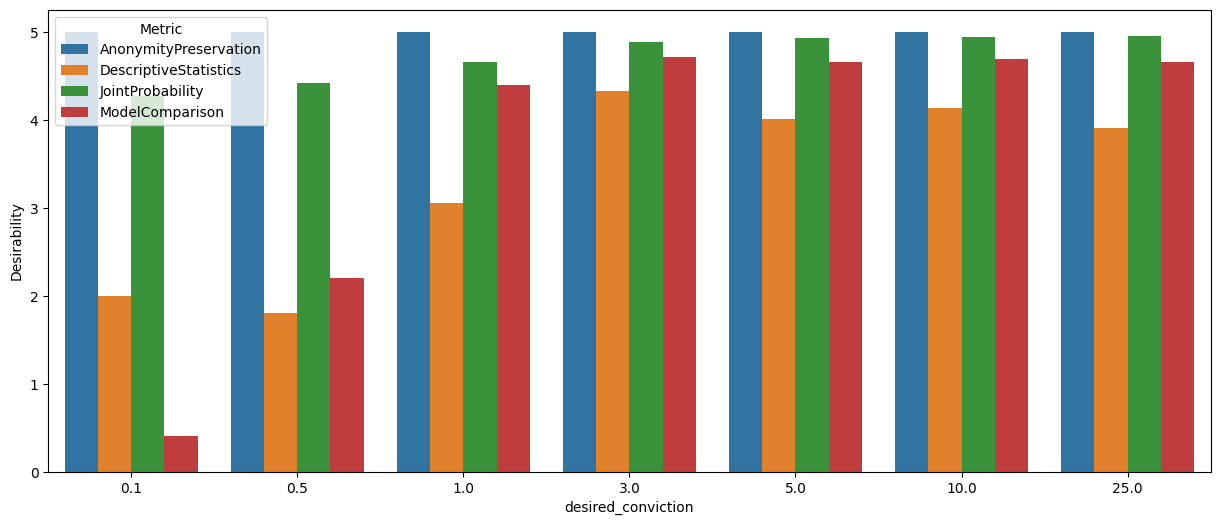

In [9]:
import matplotlib.pyplot as plt

# Melt the dataframe to long format
melted_df = final_result.melt(
    id_vars="desired_conviction",
    value_vars=metrics,
    var_name="Metric",
    value_name="Desirability"
)

# Create grouped bar chart
plt.figure(figsize=(15, 6))
sns.barplot(data=melted_df, x="desired_conviction", y="Desirability", hue="Metric")
plt.show()

nih_age Int64 2 81
smoker_number float64 2.0 30.0
vaccine_dose Int64 1 6
nih_weight Int64 1 525


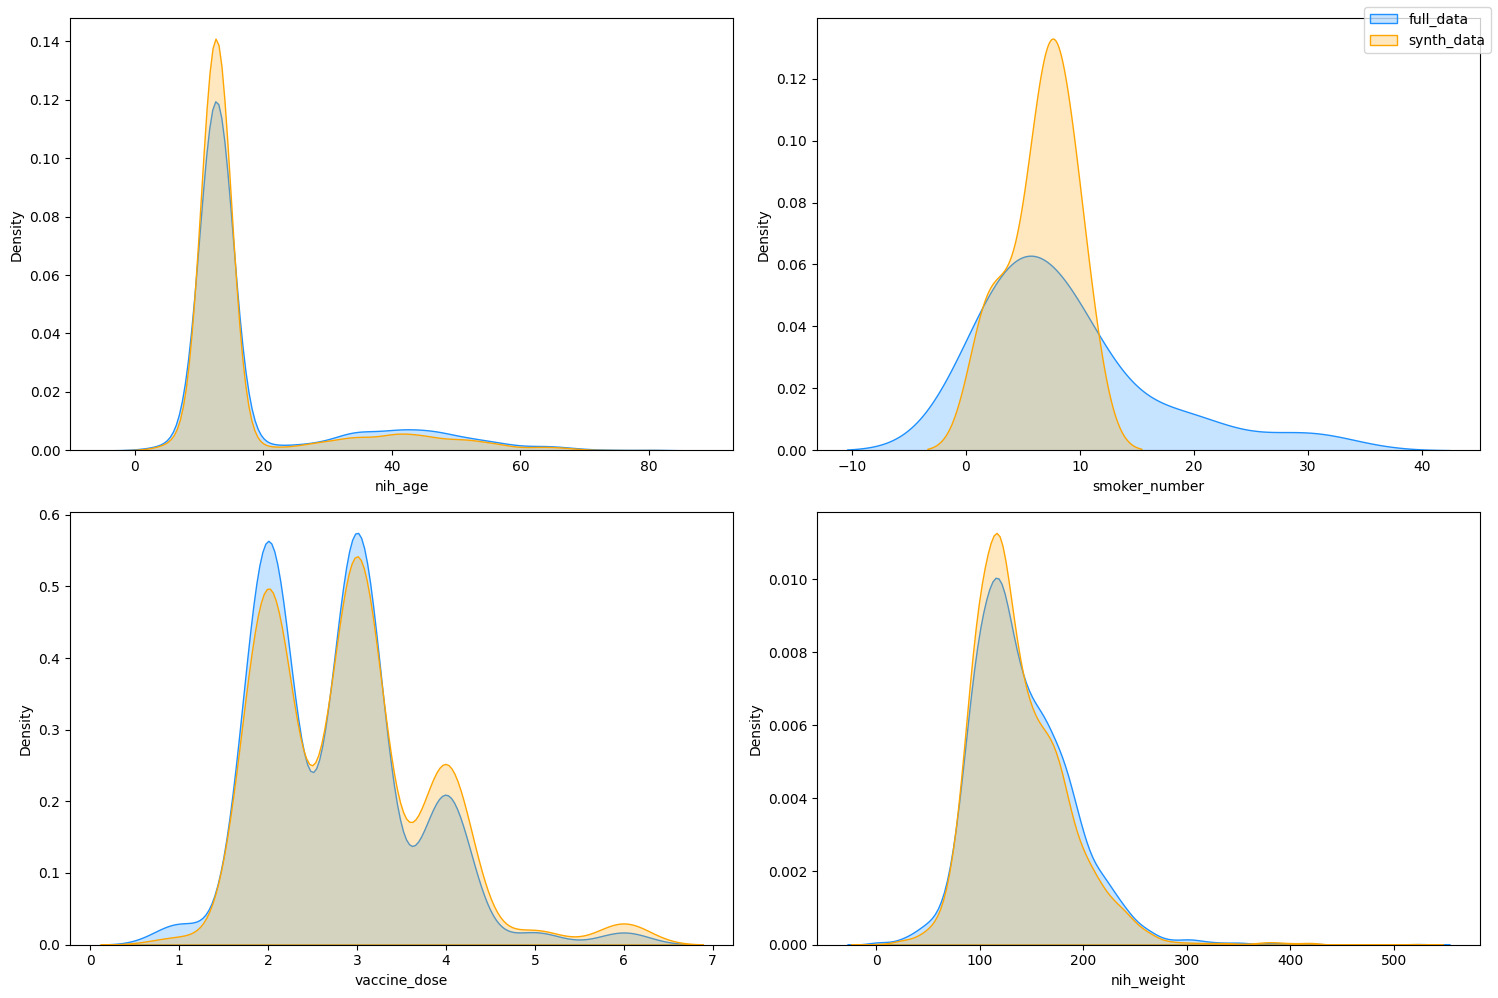

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

gen_df = synthed_dfs[-1]  # Using the one with the highest accuracy (theoretically)

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    print(c, df[c].dtypes, df[c].min(), df[c].max())
    if df[c].dtypes != 'string':
        sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
        sns.kdeplot(ax=ax, x=gen_df[c], color="orange", label="full_data", fill=True)
        ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [11]:
# Display the full ModelComparison results dataframe for the final run
with pd.option_context('display.max_rows', None):
    display(validator_results[-1]["ModelComparison"].get_dataframe())

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,race_ethn_islander_detail_2___5,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___6,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___8,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___9,None,NaN,NaN
4,1,NaN,Howso,tested_for_covid,None,NaN,NaN
5,1,NaN,Howso,covid_test_specimen_collector,None,NaN,NaN
6,1,NaN,Howso,covid_test_specimen_type,None,NaN,NaN
7,1,NaN,Howso,covid_test_tar_dis_stat_2___1,None,NaN,NaN
8,1,NaN,Howso,covid_test_tar_dis_stat_2___3,None,NaN,NaN
9,1,NaN,Howso,language_english,None,NaN,NaN
